**Notebook to filter the database and explore the data** 

---

**Objective:**  

Find the best place to locate a **gaming** company based on the requisites of the employees.
- Using the crunchbase database to access the information of around 20.000 companies.
- The database needs to be filtered according to our needs.

**Libraries**

In [1]:
import exploratory as ex
from pymongo import MongoClient
import pandas as pd
import re
import io
import folium
from folium import Choropleth, Circle, Marker, Icon, Map
import matplotlib.pyplot as plt
import seaborn as sns
# Matplotlib inline to visualize Matplotlib graphs
%matplotlib inline
%config Inlinebackend.figure_format= 'retina'
sns.set_style('whitegrid')

# Extracting companies from the database

**Establishing connection to the database**

In [2]:
c = ex.getCollection("localhost:27017", "ironhack", "crunchbase")

In [3]:
# Getting all the companies from the collection:
result = list(c.find())

**Exploring the *tags* and *categories***

In [4]:
# Looking at the distinct tags in the database:
tags = ex.getField(result,"tag_list")
# tags

In [5]:
# Looking at the distinct categories in the database:
categories = ex.getField(result,"category_code")
# categories

**Things to consider when filtering:**

- I want my company to be in a city with a **gaming industry hub**. Thus, I will select for those with **tags** related to video-games.
- Videogame companies collaborate and outsource other software-related and design companies, so I might want to have them near my company aswell. Some **categories** are interesting: 'games_video', 'software' and 'design'. 
- I want the hub to be composed of **successful** companies, so the total amount of money they raised should be >1M ($/€).
- I could filter the database by these tags and categories and then group the companies by country/city to identify a potential hub.

**Only gaming companies: a total of 285**  

The following code returns the total number of strictly gaming companies. I checked the cities where these companies tend to accumulate. The result of the search is detailed below (right before section #2). I would like my company to be in one of those cities, but I will also explore cities *enriched* with design and tech companies as they are my employee's requirements.

In [6]:
# Necessary filters: Companies whose 'offices' field is not empty and who have raised more than 1M $/€
office_filter = {'offices' : {"$ne" : []}}
money_filter = {'total_money_raised' : {"$regex" : ".*\d+[MB]"}}
necessary = {"$and" : [office_filter, money_filter]}

# If I only consider gaming companies:
tag_filter = {'tag_list' : {"$regex": ".*gaming.*|.*game.*"}}
overview_filter = {'overview' : {"$regex": ".*gaming.*|.*game.*"}}

projection = {"_id":0, "name":1, 'total_money_raised':1, 'offices':1, 'tag_list':1}

companies = list(c.find({"$or": [{"$and": [necessary, tag_filter]},
                                 {"$and": [necessary, overview_filter]}
                                        ]}, projection))

len(companies)

285

**Gaming / design / tech companies: a total of 430**  

Designers and developers account for the 41% of the company. Thus it makes sense that I satisfy their requirements by identifying a gaming-design-tech hub. 

In [7]:
# Necessary filters: Companies whose 'offices' field is not empty and who have raised more than 1M $/€
office_filter = {'offices' : {"$ne" : []}}
money_filter = {'total_money_raised' : {"$regex" : ".*\d+[MB]"}}
necessary = {"$and" : [office_filter, money_filter]}

# I need a city with a gaming hub, but that also has design and tech companies nearby for my employees:
my_regex = ".*gaming.*|.*game.*|.*design.*|.*tech.*"
tag_filter = {'tag_list' : {"$regex": my_regex}}
overview_filter = {'overview' : {"$regex": my_regex}}
category_filter = {'category_code': {"$regex": my_regex}}

projection = {"_id":0, "name":1, 'total_money_raised':1, 'offices':1, 'tag_list':1}

companies = list(c.find({"$or": [
                                    {"$and": [necessary, tag_filter, category_filter]},
                                    {"$and": [necessary, overview_filter, category_filter]}
                                        ]}, projection))

len(companies)

430

In [8]:
companies_df = pd.DataFrame(companies)
companies_df.head()

,name,tag_list,total_money_raised,offices
0,Joost,"iptv, babelgum, television, video, thevenicepr...",$45M,"[{'description': '', 'address1': '100 5th Ave ..."
1,Babelgum,"iptv, web2ireland",$13.2M,"[{'description': '', 'address1': '', 'address2..."
2,Veoh,"veoh, video, veohtv, socialvideo, videosharing...",$69.8M,"[{'description': '', 'address1': '10180 Telesi..."
3,YouTube,"channels, movies, rentals, share, usergenerate...",$11.5M,"[{'description': 'Corporate Headquarters', 'ad..."
4,Pando Networks,"p2p, video, streaming, download, cdn",$11M,"[{'description': None, 'address1': '520 Broadw..."


**Checking enrichment / filtering**

In [9]:
# When I print the tags again I see an enrichment of gaming-related tags.
tags = ex.getField(companies,"tag_list")
# print(tags)

In [10]:
# I selected companies with >1M of $/€ raised.
money = ex.getField(companies,"total_money_raised")
# print(money)

**Extracting the city, state and country for each company**  

First, I would like to get all offices and that they are added as new rows, since I want to count how many gaming industry offices are there per city/country. Defining an explode function:

In [11]:
companies_df = ex.explodeColumns(companies_df, "offices")

In [12]:
companies_df = ex.extractInfoCrunchbase(companies_df)

## Cleaning and exploring

In [13]:
# Dropping the columns I will not use: I am interested in the gaming hub location.
companies_df = companies_df.drop(columns = ['tag_list', 'offices', 'total_money_raised'])
companies_df.head()

,name,city,state_code,country_code,latitude,longitude
0,Joost,New York,NY,USA,40.746497,-74.009447
1,Babelgum,London,None,GBR,53.344104,-6.267494
2,Veoh,San Diego,CA,USA,32.902266,-117.208340
3,YouTube,San Bruno,CA,USA,37.627971,-122.426804
4,Pando Networks,New York,NY,USA,40.722655,-73.998730


In [14]:
# Top 3 countries with more companies
companies_df.groupby('country_code').size().sort_values(ascending=False).head(3)

country_code
USA    341
GBR     23
DEU     18
dtype: int64

In [15]:
# Top 3 states with more companies
companies_df.groupby('state_code').size().sort_values(ascending=False).head(3)

state_code
CA    161
MA     28
NY     25
dtype: int64

In [16]:
# Top 3 cities with more companies
companies_df.groupby('city').size().sort_values(ascending=False).head(6)

city
San Francisco          41
                       21
New York               21
Cambridge              11
South San Francisco     9
London                  8
dtype: int64

In [17]:
companies_df.groupby(['city','country_code']).size().sort_values(ascending=False).head(10)

city                 country_code
San Francisco        USA             41
New York             USA             21
South San Francisco  USA              9
Cambridge            USA              8
Austin               USA              8
Seattle              USA              8
Los Angeles          USA              7
Shanghai             CHN              7
Fremont              USA              7
London               GBR              7
dtype: int64

In [18]:
# cities_with_space = gaming_df[gaming_df['city'] == ""]
# cities_with_space

# only 8 out of the 21 cities with spaces have data of latitude/longitude.
# of those 8, 3 are in CA (USA), 2 in other states of USA, 1 in SWE, 1 in NLD and 1 in DEU
# they would not affect the ranking

**Exporting**

In [19]:
# companies_df.to_csv('../data/companies.csv', index = False)

In [20]:
plot = companies_df.groupby(['city','country_code']).size().sort_values(ascending=False).head(5)
plot_df = pd.DataFrame(plot)
plot_df = plot_df.reset_index().drop(["country_code"], axis = 1).rename(columns={0:"count"})
plot_df

,city,count
0,San Francisco,41
1,New York,21
2,South San Francisco,9
3,Cambridge,8
4,Austin,8


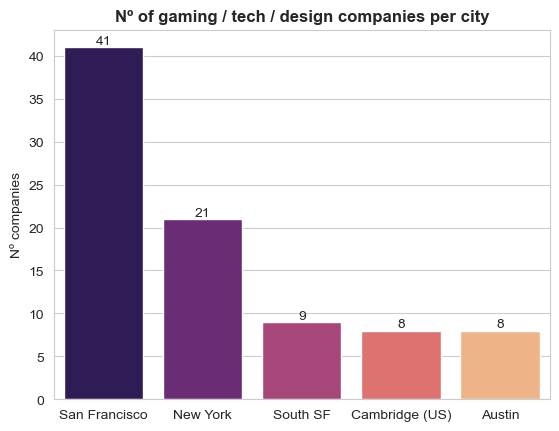

In [35]:
fig = sns.barplot(x = "city", y = "count", data = plot_df, palette = "magma")
fig.bar_label(fig.containers[0])
fig.set(ylabel = 'Nº companies', xlabel = "")
fig.set_title('Nº of gaming / tech / design companies per city', weight = "bold")
plt.xticks(ticks = [0,1,2,3,4], labels = ["San Francisco", "New York", "South SF", "Cambridge (US)", "Austin"])
plt.show()

fig.figure.savefig('../images/number_companies.jpg', dpi=1000, bbox_inches='tight')

## Comparison of hubs: gaming vs gaming-design-tech

If I consider the **gaming hub only**, then the top cities are:
1. San Francisco: 53
2. New York: 21
3. London (GBR): 13
4. Los Angeles: 10
5. Beijing: 8

On the other hand, if I consider a **gaming-design-tech hub**, then the top cities are:
1. San Francisco: 41
2. New York: 21
3. South San Francisco: 9
3. Cambridge (USA): 8
5. London (GBR): 7

**Next steps**
- **San Francisco** and **New York** seem like the best cities **in general**.
- **London (GBR)** and **Cambridge (USA)** could also be good options. Between the two I would choose **London**, since there are more gaming companies.
- I compared the maps filtering for gaming companies only **(gaming hub)** and filtering for **gaming-design-tech**, and they tend to accumulate in same places irrespectively of the of the kind of hub. Therefore, it doesn't make much of a difference.
- Now I will have to see if these cities have all the requirements.

# Building maps for each city
To see whether these companies agglomerate in one region of the city, where I would locate my company.

**Coordinates**  

Got them from Google Maps

In [22]:
sanfran_coordinates = [37.709209, -122.414242]
newyork_coordinates = [40.730610, -73.935242]
london_coordinates = [51.509865, -0.118092]
cambridge_coordinates = [42.373611, -71.110558]

**Function to create a map centered on specified coordinates**

## San Francisco

In [23]:
# Subset of the dataframe: San Francisco
sanfrancisco = companies_df[(companies_df['city'] == "San Francisco")]
sanfrancisco = sanfrancisco[sanfrancisco['latitude'].notna()]

In [24]:
map_sanfran = ex.createMap_addMarkers(sanfran_coordinates, sanfrancisco)
map_sanfran
# Company in the center: Globant (37.781929,-122.404176) / Tagged (37.775300,-122.418600)

- Most companies agglomerate to the **north-east coast** of San Francisco.
- Some companies categorized as belonging to San Francisco are actually in Palo Alto.

## New York

In [25]:
# Subset of the dataframe: New York
newyork = companies_df[(companies_df['city'] == "New York")]
newyork = newyork[newyork['latitude'].notna()]

In [26]:
map_newyork = ex.createMap_addMarkers(newyork_coordinates, newyork)
map_newyork
# Company right in the center: Cellufun (40.739930,-73.993049)

## London (GBR)

In [27]:
# Subset of the dataframe: London
london = companies_df[(companies_df['city'] == "London")]
london = london[london['latitude'].notna()]

In [28]:
map_london = ex.createMap_addMarkers(london_coordinates, london)
# map_london
# Company in the middle: spigit (51.517038, 0.139476)

## Cambridge (USA)

In [29]:
# Subset of the dataframe: Cambridge
cambridge = companies_df[(companies_df['city'] == "Cambridge")]
cambridge = cambridge[cambridge['latitude'].notna()]

In [30]:
map_cambridge = ex.createMap_addMarkers(cambridge_coordinates, cambridge)
# map_cambridge
# Company right in the center: Aileron Therapeutics

## South San Francisco

In [31]:
# Subset of the dataframe: South San Francisco
south_sanfrancisco = companies_df[(companies_df['city'] == "South San Francisco")]
south_sanfrancisco = south_sanfrancisco[south_sanfrancisco['latitude'].notna()]

# Conclusions:
- San Francisco (USA), New York (USA) and London (GBR) are the best cities based on gaming / gaming-design-tech hubs, which are the requirements of designers and developers of the company.
- I will compare which of the three is the best city based on the rest of requirements.

**Exporting all datasets**

In [32]:
# sanfrancisco.to_csv('../data/companies_sanfrancisco.csv', index = False)
# newyork.to_csv('../data/companies_newyork.csv', index = False)
# london.to_csv('../data/companies_london.csv', index = False)
# south_sanfrancisco.to_csv('../data/companies_south_sanfrancisco.csv', index = False)